# some simulation and examples for using SSB+SWPC method (in development)

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

import calculate_SSBSWPC
# import importlib
# importlib.reload(calculate_SSBSWPC)
from calculate_SSBSWPC import calculate_SSBSWPC
import seaborn as sns
import pandas as pd

## simulation parameter

In [2]:
Fs = 2                              # sampling frequency
corr_fs = .01                       # corr frequency. corr time series is a cosine with this frequency  
simulation_num = 100                # Number of simulated time series pairs
winsize = 7                         # window size used for SSB+SWPC and SWPC 
signal_Wp = np.array([.15])         # passband cutoff frequency for the passband
signal_Ws = np.array([1])*.05       # stopband cutoff frequency for the passband
signal_Ws = signal_Wp + signal_Ws
T = 400                             # length of time series in second
mod_n = 20                          # number of freq modulation for SSB. 
Tr = 1/Fs
tn = np.arange(0,400,Tr)


In this section the filter that is used to generate the simulated time series is designed and its transfer function is depicted

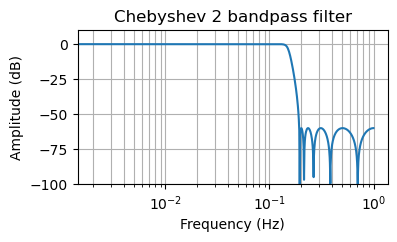

In [3]:
b, a = sp.signal.butter(6, signal_Wp/(Fs/2), btype='lowpass')
N, Wn = signal.cheb2ord(signal_Wp/(Fs/2), signal_Ws/(Fs/2), gpass=3, gstop=60)
b, a = signal.cheby2(N, 60, Wn, 'lowpass')
w, h = signal.freqz(b, a)

fig = plt.figure(figsize=[4, 2])
plt.semilogx(w / np.pi*(Fs/2), 20 * np.log10(abs(h)))
plt.title('Chebyshev 2 bandpass filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.ylim([-100, 10])
plt.grid(which='both', axis='both')

for each iteration of the simulation, generate a pair of bandlimited time sereis (determined by signal_Wp) that have a time resolved Pearson correlation equal to $0.7cos(2*\pi*f_{corr}*t)$ where $f_{corr}$ is the correaltion frequency in Hz. To achive this, we first generate two random iid signals by drawing samples from a normal distrobution. next we applied the filter designed in the previous sectionto this data. This results in a bandlimited but uncorrealted signal, i.e., $x(t)$ and $y(t)$. Next for each time point, we generate the desireds covariance matrix at that specific time point:
$$
\Sigma(t) =  \begin{bmatrix} 1 & 0.7cos(2*\pi*f_{corr}*t)\\ 0.7cos(2*\pi*f_{corr}*t) & 1 \end{bmatrix}
$$
Then we use Cholesky decomposition to decompose the matrix $\Sigma(t)$:
$$
\Sigma(t) =  LL^*
$$
where L is a lower triangular matrix and $L^*$ is its conjugate transpose. Now if we multiply the vector $[x(t), y(t)]$ of length 2 by 1 by the matrix L and repeat this for all time points we will have a pair of time series with time resolved sample Pearson correlation equal to $\rho(t) = 0.7cos(2*\pi*f_{corr}*t)$.

To evaluate the proposed method SSB+SWPC and compare it to classical SWPC, we first estimate time resolved sample Pearson correlation using both methods and then calculate the correaltion between the estimated values and the $\rho(t)$. Note that if we run the function calculate_SSBSWPC with modulation frequency set to 0, we are essentially calculating classic SWPC.



In [4]:
modfs_vec = np.linspace(0, 1/Tr/2,mod_n+1)[:-1]

all_scores = np.zeros([simulation_num, modfs_vec.shape[0], 2])
row_num = simulation_num*modfs_vec.shape[0]*2
all_scores_col = np.zeros([row_num, 3])
cnt = 0
for modn in np.arange(modfs_vec.shape[0]):
    for simn in np.arange(simulation_num):
        Tc_white = np.random.randn(tn.shape[0],2)
        
        Tc_filt = np.zeros(Tc_white.shape)
        for cn in np.arange(0, Tc_white.shape[1]):    
            Tc_filt[:,cn] = signal.filtfilt(b, a, Tc_white[:,cn])

        corr_tc = 0.7*np.cos(2*np.pi*corr_fs*tn)   
        Tc = np.zeros(Tc_filt.shape)
        for nn in np.arange(0,corr_tc.shape[0]):
            sigma = np.array([[1, corr_tc[nn]], [corr_tc[nn], 1]])
            Tc[nn,:] = np.matmul(np.linalg.cholesky(sigma),Tc_filt[nn,:])
            
        # evaluation steps
        SSBSWPC_vec, win_idx = calculate_SSBSWPC(Tc, winsize, Tr, mod_fs = modfs_vec[modn], win_type = 'rect')
        SWPC_vec, win_idx = calculate_SSBSWPC(Tc, winsize, Tr, mod_fs = 0, win_type = 'rect')
        
        all_scores[simn, modn, 0] = np.corrcoef(np.squeeze(SSBSWPC_vec),corr_tc[win_idx])[0, 1]
        all_scores[simn, modn, 1] = np.corrcoef(np.squeeze(SWPC_vec),corr_tc[win_idx])[0, 1]
        
        all_scores_col[cnt, 0] = 0
        all_scores_col[cnt, 1] = modfs_vec[modn]
        all_scores_col[cnt, 2] = np.corrcoef(np.squeeze(SSBSWPC_vec),corr_tc[win_idx])[0, 1]
        cnt = cnt + 1
        
        all_scores_col[cnt, 0] = 1
        all_scores_col[cnt, 1] = modfs_vec[modn]
        all_scores_col[cnt, 2] = np.corrcoef(np.squeeze(SWPC_vec),corr_tc[win_idx])[0, 1]
        cnt = cnt + 1
    print(f"progress {(modn+1)/modfs_vec.shape[0]*100:.2f}%", end="\r")


# to save time you can run the simulation once and save the results as a .npy file

# with open('all_scores_col.npy', 'wb') as f:
#     np.save(f, all_scores_col)

As running the simulation might takes too much time, you can load the uploaded .npy file. This file contains all_scores_col variable for when the modulation frequencies are generated using the command "np.linspace(0, 1/Tr/2,mod_n+1)[:-1]". For each modulation frequency the simulation is repeated 1000 times.  

In [71]:
# uncomment this line to load simulation results already ran
all_scores_col = np.load('all_scores_col.npy')

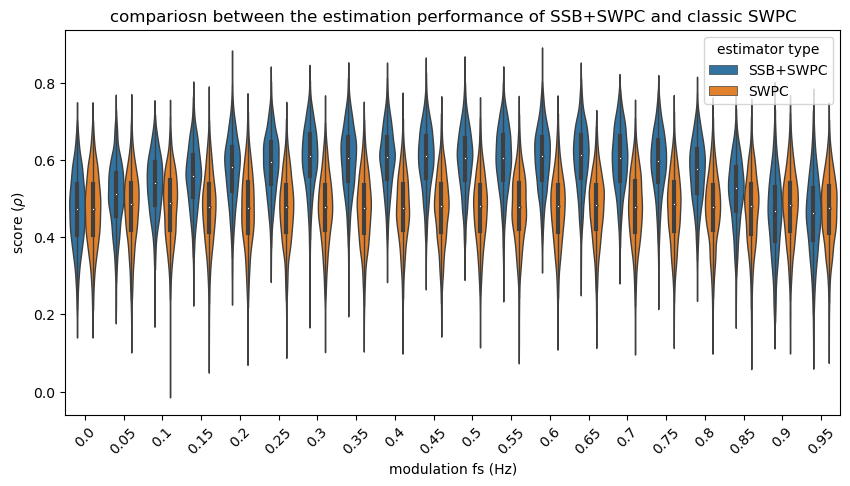

In [74]:
all_scores_df = pd.DataFrame(all_scores_col, columns = ['estimator type','modulation fs (Hz)','score'])
# these two lines is just for the legend. we actually dont need to change them for the plot itself
all_scores_df.loc[all_scores_df['estimator type']==0, 'estimator type'] = 'SSB+SWPC'
all_scores_df.loc[all_scores_df['estimator type']==1, 'estimator type'] = 'SWPC'

fig = plt.figure(figsize=[10,5])
gh = sns.violinplot(data=all_scores_df, x="modulation fs (Hz)", y="score", hue="estimator type",
               split=False, inner="box", linewidth=1)
tmp_xticks = np.unique(all_scores_col[:,1])
tmp_xticks = np.round(tmp_xticks * 1000)/1000
gh.set_xticks(np.arange(0,tmp_xticks.shape[0]))
gh.set_xticklabels(tmp_xticks)
gh.tick_params(axis='x', rotation=45)
gh.set_ylabel(r'score ($\rho$)');
gh.set_title(f'compariosn between the estimation performance of SSB+SWPC and classic SWPC');

In [1]:
import importlib
import calculate_SSBSWPC
importlib.reload(calculate_SSBSWPC)
from calculate_SSBSWPC import calculate_SSBSWPC


SSBSWPC_vec, win_idx = calculate_SSBSWPC(Tc, winsize, Tr, mod_fs = modfs_vec[modn], win_type = 'gauss', plot_flag=1)


NameError: name 'Tc' is not defined